

# CASE PROJECT

## Imports

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

## Read data from drive

In [165]:
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search.
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")

def read_store_files(files_path, file_type='.csv'):
  '''
    :files_path: The complete Drive path that includes the files
  '''

  data_list = []
  files_names = []
  for file in os.listdir(files_path):
    if file.endswith(file_type):
      file_path = os.path.join(files_path, file)
      if file_type == '.csv':
        data = pd.read_csv(file_path)
      elif file_type == '.xlsx':
        data = pd.read_excel(file_path)

      data_list.append(data)
      files_names.append(file)

  return data_list, files_names

In [166]:
def zero_pad_filenames(annotation_files_names):
    # Create a list to hold the zero-padded filenames
    padded_filenames = []

    for filename in annotation_files_names:
        # Extract the number part from the filename
        parts = re.split(r'(\d+)', filename)
        # Zero-pad the number part
        parts[1] = parts[1].zfill(2)
        # Reconstruct the filename
        padded_filename = ''.join(parts)
        padded_filenames.append(padded_filename)

    return padded_filenames

In [167]:
def sort_data(files_names, data):
    # Get the zero-padded filenames
    padded_filenames = zero_pad_filenames(files_names)
    
    # Create a list of tuples (padded_filename, original_filename, annotation_data)
    combined_list = list(zip(padded_filenames, files_names, data))

    # Sort the combined list based on the zero-padded filenames
    combined_list.sort()

    # Unzip the sorted list back into the separate components
    sorted_filenames = [original_filename for _, original_filename, _ in combined_list]
    sorted_data = [data for _, _, data in combined_list]

    return sorted_filenames, sorted_data

In [168]:
# Retrieve folders
annotations_folder = 'CASE_full/data/interpolated/annotations'
physiological_folder = 'CASE_full/data/interpolated/physiological'
metadata_folder = 'CASE_full/metadata'

print(f'Path of Annotation files: {annotations_folder}')
print(f'Path of Physiological files: {physiological_folder}')
print(f'Path of metadata files: {metadata_folder}')

# Retrieve data files
annotation_data, annotation_files_names = read_store_files(annotations_folder)
physio_data, physio_files_names = read_store_files(physiological_folder)

annotation_files_names, annotation_data = sort_data(annotation_files_names, annotation_data)
physio_files_names, physio_data = sort_data(physio_files_names, physio_data)

print(f'Number of Annotation files: {len(annotation_data)}\nNames: {annotation_files_names}')
print(f'Number of Physiological files: {len(physio_data)}\nNames: {physio_files_names}')

# Retrieve metadata
metadata, metadata_names = read_store_files(metadata_folder,'.xlsx')
print(f'Metadata names: {metadata_names}')

# Strip column names
for i in range(len(metadata)):
  metadata[i].columns = metadata[i].columns.str.strip()

for i, file in enumerate(metadata_names):
  if file == 'videos.xlsx':
    videos_data = metadata[i].drop(metadata[i].columns[2:], axis=1).drop([0]).rename(columns={'Video-label': 'label', 'Video-ID': 'video_id'}).dropna()
    videos_data['video_id'] = videos_data['video_id'].astype(int)
  elif file == 'participants.xlsx':
    participant_data = metadata[i].rename(columns={'Participant-ID': 'participant_id', 'Age-Group': 'age_group', 'Video Sequence Used': 'sequence'})

  elif file == 'videos_duration_num.xlsx':
    duration_data = metadata[i].rename(columns={'video-ID': 'video_id', 'video-duration (in ms)': 'duration'})

  elif file == 'seqs_order_num.xlsx':
    sequence_order_data = metadata[i]


del metadata

Path of Annotation files: CASE_full/data/interpolated/annotations
Path of Physiological files: CASE_full/data/interpolated/physiological
Path of metadata files: CASE_full/metadata
Number of Annotation files: 30
Names: ['sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', 'sub_25.csv', 'sub_26.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_30.csv']
Number of Physiological files: 30
Names: ['sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', '

## Pre-processing

### Align physio and annotation data

In [169]:
def align_and_average_physio_data(ratio, physio_data, annotation_data):
    '''
    :ratio: How many physiological data correspond to each annotation point.
    :physio_data: The physiological data for all participants.
    :annotation_data: The annotation data for all participants.
    '''
    simplified_physio = []

    for i in range(len(physio_data)):
        physio_data[i]['segment_id'] = (physio_data[i]['video'].diff(1) != 0).cumsum()
        annotation_data[i]['segment_id'] = (annotation_data[i]['video'].diff(1) != 0).cumsum()

        grouped_physio = physio_data[i].groupby('segment_id')
        averaged_data = []

        for segment_id, segment in grouped_physio:
            if segment_id in annotation_data[i]['segment_id'].values:
                # Ensure bins start at the minimum daqtime for the segment and don't overlap
                min_time = segment['daqtime'].min()
                max_time = segment['daqtime'].max()

                # Adjust bins to align exactly with the segment's range
                start_bin_edge = np.floor(min_time / ratio) * ratio
                end_bin_edge = np.ceil((max_time + 1) / ratio) * ratio
                bins = np.arange(start_bin_edge, end_bin_edge, ratio)

                segment['bin'] = pd.cut(segment.daqtime, bins, right=False, labels=bins[:-1])

                # Group by bins and calculate the mean
                binned_data = segment.groupby('bin').mean().reset_index(drop=True)
                binned_data['video'] = segment['video'].iloc[0]

                averaged_data.append(binned_data)

        # Concatenate all processed segments
        if averaged_data:
            full_averaged_data = pd.concat(averaged_data).reset_index(drop=True)

            # Take the first row of the physiological data to ass it at timepoint 0
            first_row = pd.DataFrame([physio_data[i].iloc[0]])
            # Concantate this row with the computed dataframe
            full_averaged_data = pd.concat([first_row, full_averaged_data]).reset_index(drop=True)
            # Add the timepoints of the annotation data to the new dataframe
            full_averaged_data['daqtime'] = annotation_data[i]['jstime']
            # Transform video values to int
            full_averaged_data['video'] = full_averaged_data['video'].astype(int)
            simplified_physio.append(full_averaged_data.drop(columns='segment_id'))

    return simplified_physio

In [170]:
# How many physio data for each annotation
annotation_physio_time_ratio = int(np.round(len(physio_data[0]) / len(annotation_data[0])))
print(f'There are {annotation_physio_time_ratio} physiological data for each 1 annotation.')

# Call the alignment function
aligned_physio_data = align_and_average_physio_data(annotation_physio_time_ratio, physio_data, annotation_data)
print(f'Physio data are aligned with annotation data. Shape: {aligned_physio_data[0].shape}')

There are 50 physiological data for each 1 annotation.
Physio data are aligned with annotation data. Shape: (49032, 10)


### Plot the aligned physiological data

In [171]:
def plot_segmented_data(data, metric, participant_index):    
    # Plotting
    _, ax = plt.subplots(figsize=(18, 6))  # Set the figure size as needed

    # Extract time and ECG data
    time = data[participant_index].iloc[:, [0]].values.flatten()
    extracted_metric = data[participant_index][metric]
    video_ids = data[participant_index]['video']

    # Plot metric data
    ax.plot(time, extracted_metric, label=metric, color='black')

    # Check and convert if 'time' or 'video_ids' are pandas Series
    if isinstance(time, pd.Series):
        time = time.values  # Convert to numpy array
    if isinstance(video_ids, pd.Series):
        video_ids = video_ids.values  # Convert to numpy array

    # Include the first video segment from the start
    ax.axvline(x=time[0], color='red', linestyle='--', linewidth=0.5)

    # Initial settings for the first segment
    start_time = time[0]

    # Find indices where video changes and plot vertical lines and labels
    change_indices = np.where(np.diff(video_ids) != 0)[0]

    # Iterate through each change index and plot lines and labels
    for idx in change_indices:
        end_time = time[idx]
        mid_point = (start_time + end_time) / 2  # Calculate midpoint for label placement
        
        if video_ids[idx] in [7,8] or video_ids[idx+1] in [7,8]:
            ax.axvline(x=end_time, color='blue', linestyle='-', linewidth=1.5)
        else:
            ax.axvline(x=end_time, color='red', linestyle='--', linewidth=0.5)
        video_label = videos_data.loc[videos_data['video_id'] == video_ids[idx], 'label'].iloc[0]
        ax.text(mid_point, ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f'{video_label}', verticalalignment='bottom', fontsize=8, horizontalalignment='center')
        start_time = end_time  # Update start time for next segment

    # Handle the last segment manually
    last_idx = len(time) - 1  # Access last index properly
    ax.axvline(x=time[last_idx], color='red', linestyle='--', linewidth=0.5)
    video_label = videos_data.loc[videos_data['video_id'] == video_ids[-1], 'label'].iloc[0]
    ax.text((start_time + time[last_idx]) / 2, ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]), f'{video_label}', verticalalignment='bottom', fontsize=8, horizontalalignment='center')




    ax.set_ylabel(str(metric).upper())  # Update units according to your data
    ax.set_title(f'{str(metric).upper()} Data Segmented by Video')
    ax.set_xticklabels([])
    plt.show()

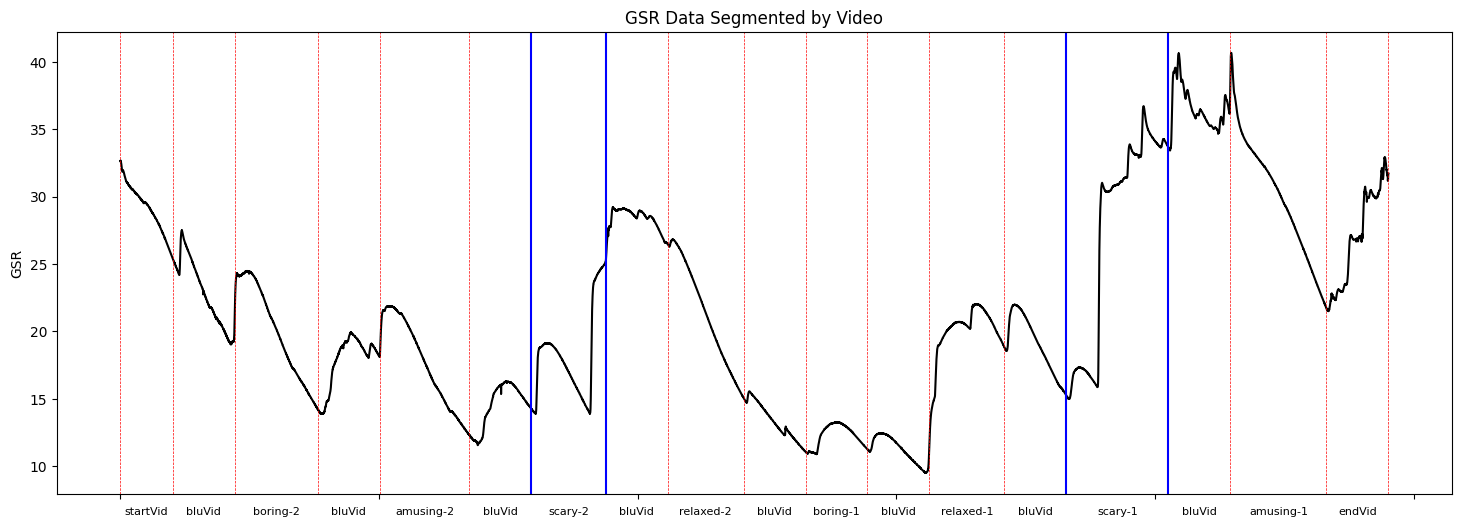

In [172]:
plot_segmented_data(aligned_physio_data, 'gsr', 3)

In [173]:
aligned_physio_data[0].tail(3)

,daqtime,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,video
49029,2451450,0.91204,35.75564,7.24226,27.03226,26.87704,5.90172,5.71434,5.44258,12
49030,2451500,0.94746,35.76266,7.24492,27.03320,26.88074,5.70540,5.78750,5.39482,12
49031,2451550,0.98932,35.71354,7.24486,27.03000,26.87874,5.78178,5.70040,5.29972,12


### Extract specific participant data

In [174]:
def process_participants(
    aligned_physio_data, 
    sequence_order_data, 
    participant_data, 
    videos_data, 
    duration_data, 
    results_name,
    SCARY_LABELS=['scary-1', 'scary-2'], 
    AMUSING_LABELS=['amusing-1', 'amusing-2'], 
    LOW_AROUSAL_LABELS=['relaxed-1', 'relaxed-2', 'boring-1', 'boring-2']
    
):

    # Extract video IDs based on labels
    def extract_video_ids(label_list):
        return videos_data[videos_data['label'].isin(label_list)].drop(columns=('label'))['video_id'].tolist()

    scary_videos_ids = extract_video_ids(SCARY_LABELS)
    amusing_videos_ids = extract_video_ids(AMUSING_LABELS)
    low_arousal_videos_ids = extract_video_ids(LOW_AROUSAL_LABELS)

    # Initialize arrays
    num_participants = len(aligned_physio_data)
    def initialize_arrays(shape, fill_value=0):
        return np.zeros(shape) + fill_value


    sequences_of_participants = np.array([participant_data.iloc[participant]['sequence'] for participant in range(num_participants)])

    interlude_durations = initialize_arrays(num_participants) # Interlude time between scary videos for each participant
    max_gsr = initialize_arrays((num_participants, 4))  # Initialize GSR and time array
    count_time_low_before_2nd = initialize_arrays((num_participants, 2))  # Initialize count and time of low arousal videos before the 2nd scary video
    count_interlude_videos_total = initialize_arrays(num_participants)  # Initialize count of interlude videos total
    count_interlude_low_arousal = initialize_arrays(num_participants) # Initialize count of interlude low arousal
    logratio_low_div_total = initialize_arrays(num_participants)  # Initialize log ratio (low arousal / total interlude)


    # Helper function to compute interlude durations
    def compute_interlude_duration(videos):
        return sum(duration_data[duration_data['video_id'] == video]['duration'].values[0]
                for video in videos if not duration_data[duration_data['video_id'] == video].empty)

    # Helper function to compute log ratio
    def compute_log_ratio(count_low, count_total):
        return np.around(np.log((count_low + 1) / (count_total + 1)), decimals=4)

    # Process each participant
    for participant in range(num_participants):
        print('\n', '#' * 15, f'Participant {participant + 1}', '#' * 15)
        participant_sequence = pd.DataFrame(sequence_order_data.iloc[:, sequences_of_participants[participant] - 1])

        # Get indices of scary videos for the current participant
        scary_indices = participant_sequence[participant_sequence[f'sub_{participant+1}'].isin(scary_videos_ids)].index
        scary_ids = participant_sequence[participant_sequence[f'sub_{participant+1}'].isin(scary_videos_ids)][f'sub_{participant+1}'].values.tolist()

        if len(scary_indices) >= 2: # More than one scary video found
            first_scary_loc, second_scary_loc = scary_indices[0], scary_indices[1]
            first_scary_start_time = aligned_physio_data[participant][aligned_physio_data[participant]['video'] == scary_ids[0]]['daqtime'].iloc[0]
            second_scary_start_time = aligned_physio_data[participant][aligned_physio_data[participant]['video'] == scary_ids[1]]['daqtime'].iloc[0]

            print(f'Scary videos order: {scary_ids} with indices: {first_scary_loc} and {second_scary_loc}')

            # Extract interlude videos
            interlude_videos = participant_sequence.iloc[first_scary_loc + 1:second_scary_loc][f'sub_{participant + 1}'].values.tolist() if second_scary_loc > first_scary_loc + 1 else []
            count_interlude_videos_total[participant] = np.floor(len(interlude_videos) / 2)
            count_interlude_low_arousal[participant] = len([vid for vid in interlude_videos if vid in low_arousal_videos_ids])
            
            logratio_low_div_total[participant] = compute_log_ratio(count_interlude_low_arousal[participant], count_interlude_videos_total[participant])
            interlude_durations[participant] = compute_interlude_duration(interlude_videos)

            print(f'Interlude videos: {interlude_videos}, Without BlueVid: {count_interlude_videos_total[participant]}')
            print('Low arousal videos:', count_interlude_low_arousal[participant])
            print(f'Interlude duration: {interlude_durations[participant]} ms')

            # Compute amusing videos
            amusing_vid_places = [i + 1 for i, video in enumerate(interlude_videos) if video in amusing_videos_ids]
            amusing_video_comments = ['early' if place <= len(interlude_videos) / 2 else 'late' for place in amusing_vid_places]

            print(f'The interlude amusing videos appear in places: {amusing_vid_places}, ({amusing_video_comments})')

            # Compute low arousal videos before 2nd scary video
            count_low_arousal_before_2nd_scary = len(interlude_videos) - amusing_vid_places[-1] if amusing_vid_places else len(interlude_videos)
            count_time_low_before_2nd[participant][0] = np.floor(count_low_arousal_before_2nd_scary / 2)
            count_time_low_before_2nd[participant][1] = compute_interlude_duration(interlude_videos[-count_low_arousal_before_2nd_scary:]) if amusing_vid_places else interlude_durations[participant]

            print(f'Low arousal videos before 2nd scary video: {count_low_arousal_before_2nd_scary} {count_time_low_before_2nd[participant][0]}')
            print(f'Count and duration of uninterrupted low arousal videos before 2nd scary video: {int(count_time_low_before_2nd[participant][0])}, {count_time_low_before_2nd[participant][1]}')

            # Compute peak GSR for each scary video
            for idx, loc in enumerate([first_scary_loc, second_scary_loc]):
                video_id = scary_ids[idx]
                start_time = first_scary_start_time if idx == 0 else second_scary_start_time
                filtered_data = aligned_physio_data[participant][aligned_physio_data[participant]['video'] == video_id]

                peak_gsr_row = filtered_data.loc[filtered_data['gsr'].idxmax()]

                max_gsr[participant][idx * 2] = peak_gsr_row['daqtime'] - start_time
                max_gsr[participant][idx * 2 + 1] = peak_gsr_row['gsr']

                print(f'Video {video_id}: Peak GSR {max_gsr[participant][idx * 2 + 1]} at {max_gsr[participant][idx * 2]} (relative time)')

        else:
            print("Less than two scary videos found for participant.")

    data = {
        'Part.': range(1, num_participants + 1),
        'Interl. Dur.': interlude_durations[:],
        'Interl. Vid. Count': count_interlude_videos_total[:],
        'Interl. Low Ar.': count_interlude_low_arousal[:],
        'Ratio': logratio_low_div_total[:],
        
        'Low Ar. vid. bfr 2nd': count_time_low_before_2nd[:, 0],
        'Low Ar. time bfr 2nd': count_time_low_before_2nd[:, 1],
            
        'Max GSR 1st': max_gsr[:, 1],
        'Max GSR 1st Time': max_gsr[:, 0],  
        'Max GSR 2nd': max_gsr[:, 3],
        'Max GSR 2nd Time': max_gsr[:, 2],
        
        'Diff. GSR': max_gsr[:, 3] - max_gsr[:, 1],
        'Diff. GSR Time': max_gsr[:, 2] - max_gsr[:, 0],
    }
    results_df = pd.DataFrame(data)

    results_df.to_csv(results_name, index=False)

    results_df.to_csv(results_name, index=False)


In [175]:
process_participants(
    aligned_physio_data, 
    sequence_order_data, 
    participant_data, 
    videos_data, 
    duration_data, 
    'results_standard.csv'
)


 ############### Participant 1 ###############
Scary videos order: [7, 8] with indices: 8 and 16
Interlude videos: [11, 4, 11, 2, 11, 6, 11], Without BlueVid: 3.0
Low arousal videos: 2.0
Interlude duration: 959958.333 ms
The interlude amusing videos appear in places: [4], (['late'])
Low arousal videos before 2nd scary video: 3 1.0
Count and duration of uninterrupted low arousal videos before 2nd scary video: 1, 386750.0
Video 7: Peak GSR 17.22866 at 180950.0 (relative time)
Video 8: Peak GSR 6.95756 at 143650.0 (relative time)

 ############### Participant 2 ###############
Scary videos order: [8, 7] with indices: 8 and 16
Interlude videos: [11, 1, 11, 3, 11, 5, 11], Without BlueVid: 3.0
Low arousal videos: 2.0
Interlude duration: 929375.0 ms
The interlude amusing videos appear in places: [2], (['early'])
Low arousal videos before 2nd scary video: 5 2.0
Count and duration of uninterrupted low arousal videos before 2nd scary video: 2, 623791.667
Video 8: Peak GSR 35.31638 at 90150.0 (r

In [176]:
pd.read_csv('results_standard.csv').head(10)

,Part.,Interl. Dur.,Interl. Vid. Count,Interl. Low Ar.,Ratio,Low Ar. vid. bfr 2nd,Low Ar. time bfr 2nd,Max GSR 1st,Max GSR 1st Time,Max GSR 2nd,Max GSR 2nd Time,Diff. GSR,Diff. GSR Time
0,1,959958.333,3.0,2.0,-0.2877,1.0,386750.000,17.22866,180950.0,6.95756,143650.0,-10.27110,-37300.0
1,2,929375.000,3.0,2.0,-0.2877,2.0,623791.667,35.31638,90150.0,42.29434,71200.0,6.97796,-18950.0
2,3,1237458.333,4.0,2.0,-0.5108,1.0,400125.000,34.43968,133150.0,35.91654,117350.0,1.47686,-15800.0
3,4,890541.667,3.0,3.0,0.0000,3.0,890541.667,25.19844,143700.0,36.69738,148950.0,11.49894,5250.0
4,5,623791.667,2.0,2.0,0.0000,2.0,623791.667,47.88054,76200.0,45.35416,19950.0,-2.52638,-56250.0
5,6,693208.333,2.0,1.0,-0.4055,0.0,120000.000,11.39356,22700.0,13.71338,64550.0,2.31982,41850.0
6,7,998791.666,3.0,1.0,-0.6931,0.0,120000.000,26.29946,183700.0,29.00698,117550.0,2.70752,-66150.0
7,8,959958.333,3.0,2.0,-0.2877,1.0,386750.000,42.99344,181250.0,34.95150,143700.0,-8.04194,-37550.0
8,9,929375.000,3.0,2.0,-0.2877,0.0,120000.000,17.50786,143700.0,38.16664,121700.0,20.65878,-22000.0
9,10,1769333.333,6.0,4.0,-0.3365,1.0,385125.000,29.15166,143700.0,36.12306,65500.0,6.97140,-78200.0


## Plot HR and GSR for scary videos

In [177]:
# Load your CSV file
df = pd.read_csv('results_standard.csv')

# Compute the correlation matrix for the DataFrame
correlation_matrix = df.corr()

# Assuming the first six columns are the columns of interest
columns_of_interest = df.columns[1:7]
all_other_columns = df.columns[7:]  # Modify if different columns are of interest

# Create a new DataFrame to store the correlations
filtered_correlations = pd.DataFrame()

for col in columns_of_interest:
    # Extract correlations of 'col' with all other columns
    correlations = correlation_matrix[col][all_other_columns]
    # Store these correlations in the new DataFrame
    filtered_correlations[col] = correlations

# Save the filtered correlations to a new CSV file
filtered_correlations.to_csv('filtered_correlations.csv')

print("Filtered correlations have been saved to 'filtered_correlations.csv'.")


Filtered correlations have been saved to 'filtered_correlations.csv'.


In [178]:
filtered_correlations

,Interl. Dur.,Interl. Vid. Count,Interl. Low Ar.,Ratio,Low Ar. vid. bfr 2nd,Low Ar. time bfr 2nd
Max GSR 1st,-0.128162,-0.131042,-0.077485,0.077388,0.099934,0.099866
Max GSR 1st Time,0.227464,0.215083,0.156193,-0.105794,-0.089533,-0.074810
Max GSR 2nd,-0.124597,-0.113345,-0.051417,0.118234,0.167202,0.156471
Max GSR 2nd Time,-0.105479,-0.108928,-0.090992,0.022871,0.071139,0.087230
Diff. GSR,0.035436,0.056373,0.055702,0.040237,0.072776,0.057507
Diff. GSR Time,-0.342019,-0.332848,-0.253933,0.132159,0.165066,0.166484
